In [21]:
from dotenv import load_dotenv

load_dotenv()

True

In [24]:
# MessageState è una classe TypedDict 
# class MessageState(TypedDict):
#     messages: Annotated[list[AnyMessages], add_messages]
# aggiunge sempre l'ultimno messaggio alla lista messages
from langgraph.graph import END, START, StateGraph, MessagesState

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
# possiamo utilizzare la classe ToolNode che convertirà il nostro tool in un nodo del grafo
from langgraph.prebuilt import ToolNode

from typing import Literal

In [25]:
# creiamo il nostro tool
@tool 
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["munich"]:
        return "It's 15 degrees Celsius and cloudly."
    else:
        return "It's 32 degrees Celsius and sunny."

In [26]:
get_weather.invoke(input={"location": "munich"})

"It's 15 degrees Celsius and cloudly."

In [27]:
tools = [get_weather]
model = ChatOpenAI(model="gpt-4o").bind_tools(tools)

In [28]:
model.invoke("hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 45, 'total_tokens': 56, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-c1a44479-7b8f-44c2-afba-b12f04c88895-0', usage_metadata={'input_tokens': 45, 'output_tokens': 11, 'total_tokens': 56, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [29]:
model.invoke("How is the weather in munich?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ofml82CqvrHtJwuJOvwhMQAe', 'function': {'arguments': '{"location":"munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 52, 'total_tokens': 68, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-296935ce-3d12-44fd-8af4-6adce1c4b50d-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'munich'}, 'id': 'call_ofml82CqvrHtJwuJOvwhMQAe', 'type': 'tool_call'}], usage_metadata={'input_tokens': 52, 'output_tokens': 16, 'total_tokens': 68, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning'

In [30]:
# per integrare sudetto flusso in langgraph dobbiamo prima creare le funzioni 
# che aggiungeremo come nodi al nostro workflow

def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    return {"messages": [response]} # aggiungiamo solo l'ultimo messaggio, dato che usiamo la reduce function (add_message), che è la responsabile di aggiungere tale response dal modello alla message list.


# funzione per arco codizionale
def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"

In [31]:
# creiamo il nostro workflow (grafo)
workflow = StateGraph(MessagesState)
# utilizziamo un nodo speciale il quale è un tool node, e solo li passiamo la lista di tools
# questo è molto conveniente perchè possiamo aggiungere un nodo che esegue un tool
# e restituisce una risposta ToolMessage() che viene inserita nello stato del grafo sotto la chiave che si usa nell'input che gli si è dato in questo caso 'messages'
# vedi: https://langchain-ai.github.io/langgraph/how-tos/tool-calling/#manually-call-toolnode 
tool_node = ToolNode(tools)

workflow.add_node("agent", call_model)

# il secondo nodo sarà il ToolNode dove li forniamo il nostro tool_node che abbiamo creato dalla
# nostra lista di tools
workflow.add_node("tools", tool_node)


# settiamo l'entry point del grafo
workflow.add_edge(START, "agent") # due in colpo solo (entrypoint e arco)


workflow.add_conditional_edges(
    "agent",
    should_continue,
    path_map={"tools": "tools", "__end__": END}
)

workflow.add_edge("tools", "agent") # torna indietro

graph = workflow.compile()


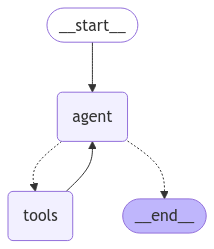

In [32]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [33]:
# creaimo i messaggi 
from langchain_core.messages import HumanMessage

message1 = [HumanMessage(content="Hello, how are you?")]
message2 = [HumanMessage(content="How is the weather in munich?")]


In [34]:
# non chiama il tool e va subito verso il nodo end
graph.invoke({"messages": message1})

{'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='9474ab0f-d244-4d12-ab8a-7becf265149b'),
  AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 50, 'total_tokens': 82, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-cdd93cef-41ad-4929-a5df-a6aec9e4c3e0-0', usage_metadata={'input_tokens': 50, 'output_tokens': 32, 'total_tokens': 82, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [35]:
# col secondo messaggio va a chiamare il tool get_weather e quindi va verso il nodo Tool che esegue il tooò
# poi ritorna in agent che poi va in end
graph.invoke({"messages": message2})

{'messages': [HumanMessage(content='How is the weather in munich?', additional_kwargs={}, response_metadata={}, id='e10d9b21-81dd-40a1-b050-ee7c53e611b4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_SrM2MuCdSH4wRMOcnMuPolJI', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 52, 'total_tokens': 68, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a5906704-6e12-48ef-856b-03a1285f847c-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_SrM2MuCdSH4wRMOcnMuPolJI', 'type': 'tool_call'}], usage_metadata={'inpu

In [36]:
graph.invoke(
    {"messages": [HumanMessage(content="What would you recommend to do in that city than?")]}
)

{'messages': [HumanMessage(content='What would you recommend to do in that city than?', additional_kwargs={}, response_metadata={}, id='2da7152a-af80-4c1b-ad04-b70d2e1c8c77'),
  AIMessage(content='Sure, I can help with that! Could you please tell me which city you are interested in?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 55, 'total_tokens': 77, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-5a234845-4ee3-4e98-b692-77da35e48d65-0', usage_metadata={'input_tokens': 55, 'output_tokens': 22, 'total_tokens': 77, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

come vediamo una volta arrivati alla fine del grafo nel nodo END lo stato viene restituito e non può essere cambiato. se diamo in input un nuovo messaggio lo stato rinizia da zero quindi sarà di nuovo il primo messaggio e pertanto non sa di che città si sta parlando dato che si inizia con una history completamente nuova per l'LLM.

Se vogliamo peroformare una conversazione reale col LLM, dobbiamo usare un layer persistente.

LangGraph ha un layer persistente incorporato chiamato **checkpoint**.

### Memory with checkpoints

Se vogliamo avere una conversazione reale con gli LLM, abbiamo bisogno di qualche tipo di persistenza per memorizzare effettivamente la conversazione.

LangGraph ha incorporato un layer persistente, e che è implementato con checkpoiinters.

Il più semplice è un memory checkpointer, dunque memorizziamo tutto in memoria, non abbiamo bisogno di una database per farlo.

Dobbiamo importare la classe memory saver dal modulo chekpoint.memory e poi creaiamo una isatnza di MemorySaver()

In [43]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

In [44]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.add_edge(START, "agent") # due piccioni con una fava

workflow.add_conditional_edges(
    "agent",
    should_continue,
    path_map={"tools": "tools", "__end__": END}
)


workflow.add_edge("tools", "agent")

# quando andiamo a compilare passiamo il chekpointer come argomento
graph = workflow.compile(checkpointer=checkpointer)


#per usrae il checkpointer, dentro il metodo invoke possiamo non solo passare
i messaggi ma anche passare il config object
il config object ha un dizionario, con una chiave 'configurable'
'configurable' ha un altro dizionario e, MOLTO IMPORTANTE, dobbiamo usare "thread_id"

### Thread
Un Thread rappresenta un unico identificatore che è usato per tracciare lo stato (gli stati) di un workflow tramite checkpoints

Gli utilizziamo per memorizzare la storia, ma poi useremo un più complesso workflow **human in the loop**.

In [45]:
graph.invoke(
    {"messages": [HumanMessage(content="How is the weather in munich?")]},
    config={"configurable": {"thread_id": 1}}
)

{'messages': [HumanMessage(content='How is the weather in munich?', additional_kwargs={}, response_metadata={}, id='b53f5a7d-67fa-44bd-b497-e077367b8023'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sGqiQkncjGHpJ6ZvlqEB4Xd8', 'function': {'arguments': '{"location":"munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 52, 'total_tokens': 68, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c39434be-e6c7-461e-a79d-4432835b9a00-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'munich'}, 'id': 'call_sGqiQkncjGHpJ6ZvlqEB4Xd8', 'type': 'tool_call'}], usage_metadata={'inpu

Ora abbiamo memorizzato lo stato finale del grafo nel workflow con thread_id=1, se vogliamo riprendere la conversazione con questo stato delle cose possiamo passare un nuovo messaggio (che andrà nel nodo **agent** ed eseguirà il modello) con lo stesso **thread_id**. Dunque il nuovo messaggio andrà ad aggiungersi nello stato  

In [46]:
graph.invoke({"messages": [HumanMessage(content="What would you recommend to do in that city than?")]},
             config={"configurable": {"thread_id": 1}})

{'messages': [HumanMessage(content='How is the weather in munich?', additional_kwargs={}, response_metadata={}, id='b53f5a7d-67fa-44bd-b497-e077367b8023'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sGqiQkncjGHpJ6ZvlqEB4Xd8', 'function': {'arguments': '{"location":"munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 52, 'total_tokens': 68, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c39434be-e6c7-461e-a79d-4432835b9a00-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'munich'}, 'id': 'call_sGqiQkncjGHpJ6ZvlqEB4Xd8', 'type': 'tool_call'}], usage_metadata={'inpu